# ARIMA to predict tomorrow's closing price

## Trial on Bitcoin csv to do feature engineering and try out different models before running the model on all of other Cryptos

Import packages

In [2]:
import os
import pandas as pd
import csv
import numpy as np
from stockstats import wrap
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
df=pd.read_csv('data/bitcoin.csv',index_col='Date')  

df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-07-18,0.0,0.1,0.1,0.1,75,USD
2010-07-19,0.1,0.1,0.1,0.1,574,USD
2010-07-20,0.1,0.1,0.1,0.1,262,USD
2010-07-21,0.1,0.1,0.1,0.1,575,USD
2010-07-22,0.1,0.1,0.1,0.1,2160,USD


In [4]:
df.index = pd.to_datetime(df.index) 
df.index

DatetimeIndex(['2010-07-18', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23', '2010-07-24', '2010-07-25',
               '2010-07-26', '2010-07-27',
               ...
               '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', name='Date', length=4420, freq=None)

In [5]:
ts=df['Close'] 
ts.head() 

Date
2010-07-18    0.1
2010-07-19    0.1
2010-07-20    0.1
2010-07-21    0.1
2010-07-22    0.1
Name: Close, dtype: float64

Text(0, 0.5, 'Close Prices')

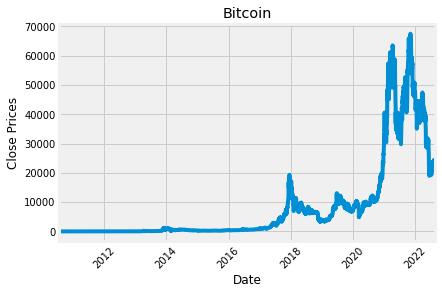

In [6]:
plt.rcParams['axes.unicode_minus'] = False  
ts.plot()         
plt.title("Bitcoin") 
plt.xticks(rotation=45)    
plt.xlabel('Date')   
plt.ylabel('Close Prices')

Distribution of the dataset

<AxesSubplot:ylabel='Density'>

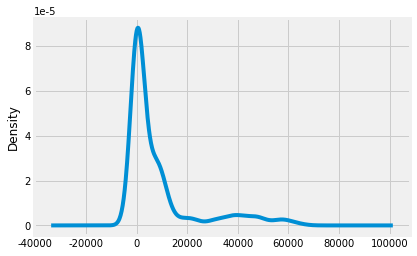

In [7]:
ts.plot(kind='kde')

Test for stationarity

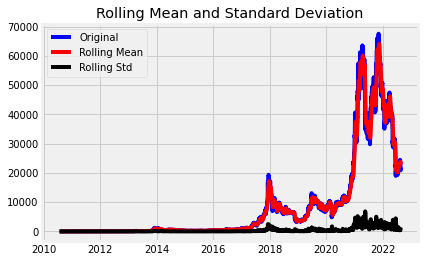

Results of dickey fuller test
Test Statistics                  -1.750985
p-value                           0.405053
No. of lags used                 31.000000
Number of observations used    4388.000000
critical value (1%)              -3.431841
critical value (5%)              -2.862199
critical value (10%)             -2.567121
dtype: float64


In [8]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ts)

Through the above graph, we can see the varying mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis. Also, the test statistics is greater than the critical values. All these justification lead to the conclusion that the series is not stationary.

To separate the trend and the seasonality from a time series, we decompose the series as follows.

<Figure size 432x288 with 0 Axes>

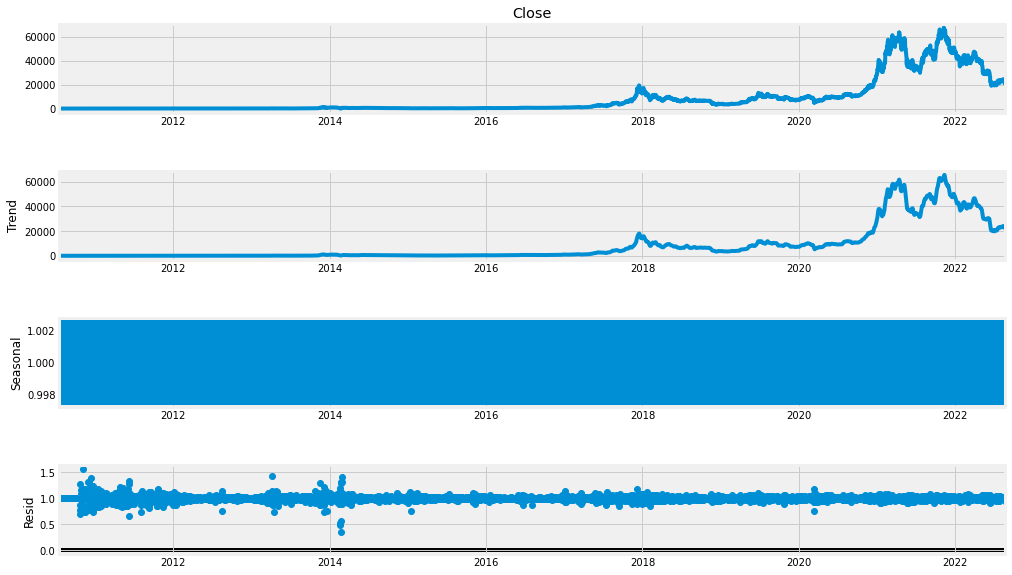

In [9]:
result = seasonal_decompose(ts, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Eliminate trend

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


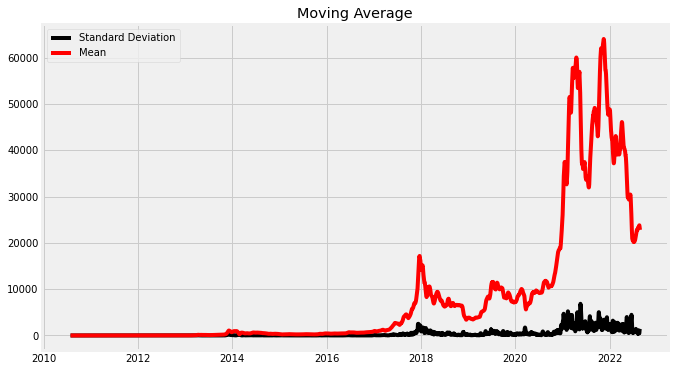

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
moving_avg = ts.rolling(12).mean()
std_dev = ts.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Split data into train and training set

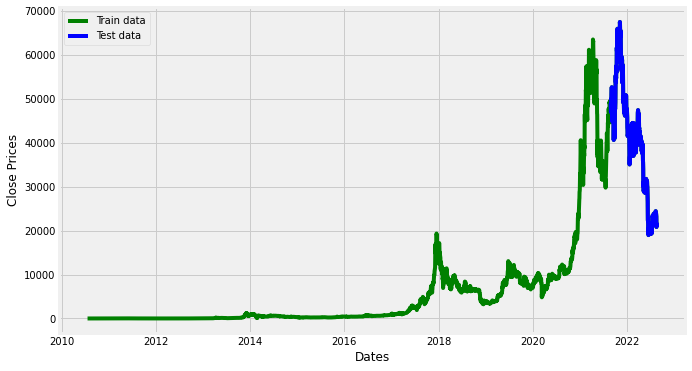

In [11]:
train_data, test_data = ts[:pd.to_datetime('2021-08-27')], ts[pd.to_datetime('2021-08-27'):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(ts, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Use AutoARIMA function to find the best params

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62382.298, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62364.424, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62367.088, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62382.435, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62345.042, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62340.681, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62341.074, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62339.991, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62355.480, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=62341.353, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=62339.419, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=62343.128, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=62341.373, Time=0.92 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=62341.121, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0

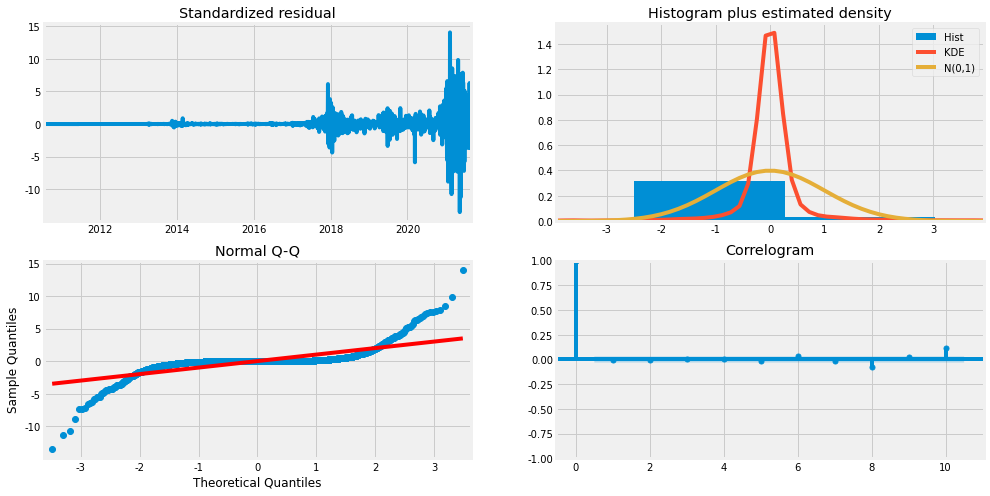

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

interpret:

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. 

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. 

Overall, it seems to be a good fit. then we start forecasting the stock prices.

Build Model

In [13]:
model = sm.tsa.arima.ARIMA(train_data, order=model_autoARIMA.order)
fitted = model.fit()

print(fitted.summary())

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4059
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -31165.132
Date:                Mon, 12 Dec 2022   AIC                          62338.265
Time:                        21:45:08   BIC                          62363.499
Sample:                    07-18-2010   HQIC                         62347.203
                         - 08-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4481      0.040     11.094      0.000       0.369       0.527
ar.L2          0.1102      0.004     24.988      0.000       0.102       0.119
ma.L1         -0.5166      0.041    -12.740      0.0

In [14]:
close_pred = fitted.forecast(test_data.size, alpha=0.05)
close_pred

2021-08-28    48771.066644
2021-08-29    48885.754692
2021-08-30    48904.826869
2021-08-31    48926.014066
2021-09-01    48937.610271
                  ...     
2022-08-20    48957.556309
2022-08-21    48957.556309
2022-08-22    48957.556309
2022-08-23    48957.556309
2022-08-24    48957.556309
Freq: D, Name: predicted_mean, Length: 362, dtype: float64

plot results

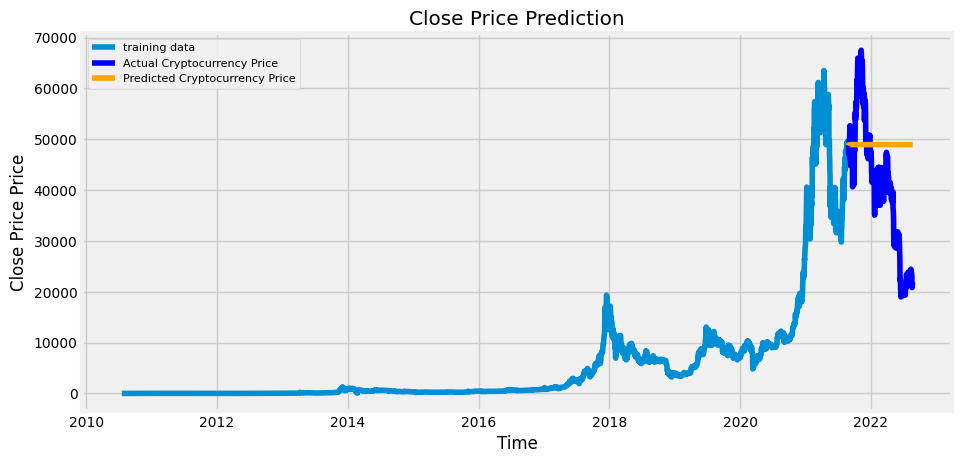

In [15]:
close_pred_series = pd.Series(close_pred, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Cryptocurrency Price')
plt.plot(close_pred_series, color = 'orange',label='Predicted Cryptocurrency Price')

plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

report performance

In [16]:
mse = mean_squared_error(test_data, close_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, close_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, close_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(close_pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 231337464.6419244
MAE: 12279.679489599499
RMSE: 15209.78187358137
MAPE: 0.422316677398636


## Apply this model in all of the crypto currencies

Get crypto file names

In [17]:
def files(dir):
    names = []
    for root, dirs, files in os.walk(dir):  
        for file in files:  
            if os.path.splitext(file)[1] == '.csv':  # csv files
                names.append(file)
    return names

In [18]:
names = files(os.getcwd() + "/data")

In [19]:
aug28_actual_price=[]
aug28_pred_price=[]

for file in names:
    df = pd.read_csv("data/"+ file,index_col='Date')
    df.index = pd.to_datetime(df.index) 
    ts_open=df['Open'] 
    ts_close=df['Close'] 
   
        # Test for stationarity
    def test_stationarity(timeseries):
        # Determing rolling statistics
        rolmean = timeseries.rolling(12).mean()
        rolstd = timeseries.rolling(12).std()
        adft = adfuller(timeseries,autolag='AIC')
        output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
        for key,values in adft[4].items():
            output['critical value (%s)'%key] =  values
    test_stationarity(ts_open)
    test_stationarity(ts_close)
    
    #if not stationary then eliminate trend
    #Eliminate trend
    moving_avg = ts_open.rolling(12).mean()
    std_dev = ts_open.rolling(12).std()
    
    moving_avg = ts_close.rolling(12).mean()
    std_dev = ts_close.rolling(12).std()
    
     #split data into train and test set
    train_data, test_data = ts_close[:pd.to_datetime('2021-08-27')], ts_close[pd.to_datetime('2021-08-27'):]

    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    
    model = sm.tsa.arima.ARIMA(train_data, order=model_autoARIMA.order)
    fitted = model.fit()
    
    close_pred = fitted.forecast(test_data.size, alpha=0.05)
    # close_pred_series = pd.Series(close_pred, index=test_data.index)
    
    open_actual = pd.Series(ts_open, index=ts_open.index)
     
    aug28_actual_price.append(open_actual.get(key = '2021-08-28'))
    aug28_pred_price.append(close_pred.iloc[0])
    
print(aug28_actual_price)
print(aug28_pred_price)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1165.107, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.293, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.175, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1165.564, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1175.208, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1174.492, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1169.675, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1164.679, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1165.441, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1171.560, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1175.565, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1164.537, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1164.647, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1174.961, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2162.012, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2160.418, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2160.363, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2163.997, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2158.026, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.645 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1256.121, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1258.119, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1258.119, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1258.587, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1247.665, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1242.218, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1248.911, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1243.898, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1243.937, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1242.934, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1247.739, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1246.216, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1243.777, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.768 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3818.102, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3755.878, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3766.882, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3816.560, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3747.483, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3747.747, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3741.607, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3740.248, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3741.577, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3752.580, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3742.142, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3738.839, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3765.584, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3754.576, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6320.931, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6292.368, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6291.002, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6319.208, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6293.000, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6293.001, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6291.670, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6289.453, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6291.452, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6291.452, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6290.774, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6290.442, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.785 seconds
Performing stepwise search to minimize aic


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4238.070, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4298.741, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4287.744, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4239.814, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4300.218, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4298.430, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4299.197, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4301.085, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4298.407, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4298.176, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4296.132, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4302.709, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4289.266, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4300.291, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4300.851, Time=0.09

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16911.407, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16909.969, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16908.993, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16909.420, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16903.412, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16886.324, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16892.399, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16888.224, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16882.801, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16886.834, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16880.445, Time=1.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16880.955, Time=1.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16890.857, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=16878.455, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.991, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.986, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=110.272, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.996, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=109.218, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=107.768, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=109.522, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=109.515, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=109.460, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=111.515, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=106.931, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=109.578, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=108.287, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=110.382, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=108.7

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2486.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2488.099, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2488.120, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2484.923, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2488.307, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.179 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1032.586, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1010.293, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1011.315, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1032.506, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1011.917, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1012.105, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1008.593, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1010.137, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=999.667, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1011.169, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1008.169, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=999.911

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1342.928, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1218.764, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=941.887, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=941.790, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=941.683, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=943.152, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=942.509, Time=0.08 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 0.529 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1353.220, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1207.712, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=833.935, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=835.429, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=834.027, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1092.313, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=824.915, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=822.426, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=834.702, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=828.855, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=821.660, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=820.882, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1023.507, 

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3066.169, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-35.429, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8278.689, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8297.314, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-8274.741, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8277.208, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8273.761, Time=1.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8294.573, Time=1.73 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 7.828 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=254.341, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=227.878, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.197, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=252.832, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=227.565, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=225.213, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=226.389, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=226.559, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=223.882, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=226.159, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=225.043, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=225.157, Time=0.23 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.074 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10771.669, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10764.731, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10762.366, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10769.708, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10708.882, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10707.591, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10749.481, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10709.054, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10685.257, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10707.757, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10709.142, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10700.069, Time=0.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10712.271, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10664.220, Time=1.87 sec
 ARIMA(3,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10052.840, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10048.518, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10047.931, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10051.256, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10047.997, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10047.753, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10049.492, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10047.870, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10047.982, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10046.301, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10046.428, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=10048.046, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=10046.445, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10046.542, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.678, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=152.546, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.261, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.267, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=152.653, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=150.997, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=152.953, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=152.949, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=153.265, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=148.893, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=150.494, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=150.885, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=154.645, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=154.821, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=153.250, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0]  

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2178.163, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2155.063, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2152.426, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2176.496, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2153.096, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2152.967, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2154.934, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2150.895, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2151.597, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2151.468, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2153.498, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2153.437, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.391 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17564.355, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17475.687, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17483.523, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17562.825, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17474.564, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17474.769, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17474.135, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17473.674, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17474.022, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17477.725, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17475.965, Time=1.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17472.302, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17482.226, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17474.364, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1017.753, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1016.417, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1015.087, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1025.609, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1009.583, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=849.119, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=851.057, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=851.052, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=847.468, Time=0.01 sec


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=847.894, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.164 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2026.514, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2025.694, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2025.816, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2024.971, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2016.921, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2015.717, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2026.708, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2000.534, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2008.989, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1970.049, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1977.885, Time=0.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1971.762, Time=1.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1969.778, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1989.966, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=170.906, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=165.710, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=162.538, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=169.193, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=157.094, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156.899, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=155.099, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=156.935, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=158.899, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=153.469, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=164.026, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=155.298, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=155.262, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=155.548, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=157.2

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9625.335, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9666.291, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9659.943, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9627.324, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9670.648, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9670.335, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9676.852, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9675.298, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9667.739, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9676.965, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9679.174, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9667.351, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9677.121, Time=1.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9665.320, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=333.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=325.154, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=322.455, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=332.003, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=324.455, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=324.455, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=320.498, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=322.498, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=322.498, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=323.190, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=320.190, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=321.027, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=321.355, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=322.744, 

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.660, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1962.783, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1975.578, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.430, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1957.585, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1958.490, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1955.518, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1959.476, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1948.151, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1955.046, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1959.290, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1949.912, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1956.140, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1940.144, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1943.169, Time=0.24 sec

Best mode

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5601.954, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10256.894, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7294.749, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-10261.419, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-10308.734, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-10357.711, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10375.287, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10266.090, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-10317.090, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10392.577, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-8301.088, Time=0.47 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10369.279, Time=0.77 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-8869.614, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10349.582, Time=0.66 sec
 ARIMA(1,

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13091.574, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13115.908, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13110.012, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13093.275, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13131.755, Time=0.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13132.294, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13129.489, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13137.613, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13138.854, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13138.616, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13123.672, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13134.905, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13140.736, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13111.618, Time=0.16 sec
 ARIM

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2870.782, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2856.086, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2858.020, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2869.388, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2853.425, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2855.166, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2844.047, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2846.324, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2845.539, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2848.283, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2842.607, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2828.084, Time=1.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2840.735, Time=0.74 sec
 ARIMA(3,1,3)(0,0,0)[0]             : 

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1175.700, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1169.821, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1171.064, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1174.365, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1169.328, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1169.845, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1164.835, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1162.842, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1164.834, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1170.516, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1166.565, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1161.636, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1169.963, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1168.725, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1632.634, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3984.085, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3855.220, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4001.143, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=118.696, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4002.469, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-486.213, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-4022.562, Time=0.39 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-3989.210, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4021.326, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-4020

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5526.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5499.018, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5499.669, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5528.444, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5499.799, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5500.665, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5466.590, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5457.897, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5458.255, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5453.476, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5436.641, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5454.658, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5440.174, Time=0.38 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] i

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1464.010, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1460.764, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1461.644, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1462.506, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1459.495, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1461.466, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1461.365, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1456.772, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1460.808, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1459.526, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1455.413, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1462.616, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1462.310, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1460.611, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8161.843, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8163.698, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8163.718, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8160.286, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8162.531, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.483 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4900.377, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4898.445, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4898.472, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4902.330, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4898.017, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.997 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3068.142, Time=0.01 sec


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3066.963, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3067.369, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3066.789, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3058.023, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3058.762, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3058.320, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3068.011, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3066.905, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3042.036, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3044.187, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3044.035, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3053.278, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3057.751, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3049.924, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3060.755, Time=0.08 sec

Best mode

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11506.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11499.768, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11498.417, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11504.143, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11497.775, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11491.530, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11493.412, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11492.020, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11435.476, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11493.432, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11432.477, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11437.335, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11432.681, Time=1.02 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=11430.519, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1480.045, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1480.646, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1480.215, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1481.103, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1487.902, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1488.449, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1482.836, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1489.314, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1487.380, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1489.794, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1490.268, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1489.327, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1489.431, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1490.874, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5561.619, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5570.906, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5570.826, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5563.300, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5568.912, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5568.921, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5566.906, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5572.526, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5570.535, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5570.545, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5572.441, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5568.528, Time=0.23 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.574 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8888.049, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8936.575, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8930.190, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8889.764, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8937.513, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8949.093, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8947.986, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8936.734, Time=1.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8950.790, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8939.148, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-8949.703, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8941.347, Time=0.52 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 3.841 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-979.719, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-978.510, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-978.281, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-981.123, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-986.025, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-999.290, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-998.700, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-998.609, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1000.473, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1002.097, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-998.265, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1000.472, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1002.147, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1003.780, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]     

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2012.794, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5920.289, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5957.301, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5863.973, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5934.465, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5924.967, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-5936.681, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5965.755, Time=2.81 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5959.523, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5966.497, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5397.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5397.271, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5397.171, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5395.912, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5399.034, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8323.679, Time=0.05 sec


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9355.129, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8713.337, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-9393.634, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-9392.434, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9389.658, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9393.028, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-9389.141, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8380.742, Time=0.23 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.902 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7622.684, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7621.735, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7621.665, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7620.712, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7623.352, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.405 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1960.350, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1965.052, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1965.707, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1961.970, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1960.777, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1964.937, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1961.715, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1967.241, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1966.348, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1966.439, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1966.603, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1963.259, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.520 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1978.147, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1960.949, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1964.427, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1976.633, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1954.499, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1956.453, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1956.388, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1952.349, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1954.348, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1954.354, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1956.349, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1950.915, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1963.053, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1959.585, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5412.568, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5425.104, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5426.281, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5414.568, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5424.493, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5425.168, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5422.352, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5428.241, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5426.466, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5427.165, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5427.104, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5424.349, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.364 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=171.082, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=169.037, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=171.586, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.203 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5753.648, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5784.494, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5779.392, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5754.994, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5795.067, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5807.580, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5808.331, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5806.212, Time=0.81 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5806.821, Time=1.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5807.311, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5805.887, Time=0.08 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 4.720 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7136.740, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7157.243, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7157.859, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7138.288, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7155.852, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7155.845, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7153.743, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7159.221, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7157.221, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7157.210, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7158.638, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7155.152, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.489 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8224.881, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8233.005, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8232.235, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8226.687, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8232.890, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8231.858, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8231.043, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8234.780, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8234.680, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8233.631, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8234.011, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8232.834, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.559 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1669.960, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=680.001, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2033.140, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2036.939, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2061.042, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-2053.670, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2059.224, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2060.564, Time=0.57 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 2.943 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1604.013, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1601.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1602.422, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1603.622, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1602.009, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1600.305, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1601.648, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1601.364, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1603.189, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1585.245, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1587.567, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1602.205, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1600.306, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1600.108, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8816.502, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7054.075, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2155.978, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2154.948, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2156.221, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2155.719, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2153.887, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5834.078, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2155.279, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5149.653, Time=0.90 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2155.836, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2148.100, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1206.758, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1196.484, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1198.542, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1205.617, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1197.265, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1197.991, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1194.338, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1192.363, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1191.330, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1190.151, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1196.367, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1191.110, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1192.996, Time=0.06 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.558 seconds
Performing stepwise se

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.590, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.518, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.694, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9.840, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.133 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=283.219, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=270.026, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=275.809, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=283.134, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=253.869, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=255.771, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=255.778, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=257.263, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=257.756, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=253.049, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=269.493, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=254.935, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=254.941, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=256.301, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=256.9

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8597.847, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8576.507, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8574.446, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8595.879, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8575.412, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8575.503, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8577.411, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8572.488, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8573.456, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8573.547, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8574.548, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8575.455, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.140 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4530.595, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12507.748, Time=0.64 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12319.265, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12490.744, Time=0.63 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12536.655, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-11025.628, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-12418.819, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12536.112, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-12527.485, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8165.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8150.310, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8151.010, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8163.958, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8151.969, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8151.878, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8151.374, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8149.212, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8150.842, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8150.741, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8149.925, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8150.242, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.450 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=303

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8844.261, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8518.001, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8872.330, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=193.847, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8873.044, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8862.070, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8865.385, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-8866.234, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-8806.789, Time=0.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.24 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8887.171, Time=2.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-8848.829, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8875.993, Time=1.70 sec
 ARIMA(3,0,2)(0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1336.508, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1290.830, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1300.363, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1334.927, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1281.705, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1275.222, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1272.364, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1294.258, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1275.314, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1274.589, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1270.987, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1271.632, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1273.874, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1274.007, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2107.046, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2129.484, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2125.454, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2108.350, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2136.380, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2144.604, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2160.533, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2152.826, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2159.587, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2157.357, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-2160.784, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2154.003, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2145.632, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-2162.297, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21560.605, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21516.493, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21525.961, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21560.462, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21490.202, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21492.012, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21490.796, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21477.689, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21479.670, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21491.360, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21476.098, Time=0.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21472.691, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21490.076, Time=0.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21377.869, Time=1.74 sec
 ARIMA(2,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13765.468, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13741.684, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13743.850, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13764.600, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13743.391, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13743.529, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13744.370, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13741.347, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13742.982, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13743.139, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13743.513, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13742.505, Time=0.18 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.713 seconds
Performing stepwise search to minimize aic


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8658.184, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8708.597, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8692.923, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8659.740, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8744.248, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8742.335, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8742.372, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8734.395, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8740.388, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8745.790, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8709.934, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8743.885, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8743.927, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8734.698, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-8741.942, Time=0.10

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=193.262, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=193.969, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=194.047, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=191.287, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=195.875, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.168 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-719.818, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-726.042, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-728.541, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-721.640, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-727.054, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-727.357, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-727.281, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-730.062, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-728.489, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-728.755, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-727.734, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-728.653, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.643 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12863.627, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12860.839, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12860.752, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12861.872, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12862.724, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12862.694, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12864.656, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12859.024, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12860.998, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12860.969, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12859.109, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12862.931, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.481 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5633.064, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5629.096, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5624.262, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5631.064, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5595.916, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5557.653, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5556.285, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5558.152, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5557.741, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5554.285, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5627.096, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5556.153, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5555.654, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5593.916, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1377.666, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1377.511, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1377.698, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1375.707, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.363 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62382.298, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62364.424, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62367.088, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62382.435, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62345.042, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62340.681, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62341.074, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62339.991, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62355.480, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=62341.353, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=62339.419, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=62343.128, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=62341.373, Time=0.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=62341.121, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4401.922, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4412.810, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4411.120, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4402.189, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4419.537, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4440.502, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4441.821, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4433.779, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4447.839, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4447.785, Time=0.97 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4436.919, Time=1.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4448.409, Time=1.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4445.554, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4434.977, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1426.071, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1436.980, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1444.173, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1427.751, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1454.624, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1459.100, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1458.751, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1457.252, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1457.275, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1458.984, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1458.366, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1455.228, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1460.354, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1455.856, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12812.393, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12795.245, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12793.774, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12810.401, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12795.562, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12795.231, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12792.615, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12762.685, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12788.796, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12752.549, Time=1.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12784.509, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12765.813, Time=1.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12753.080, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=12750.595, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3744.189, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3763.802, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3761.092, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3745.470, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3768.356, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3768.101, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3773.937, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3775.929, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3773.937, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3766.246, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3771.957, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3777.116, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3762.186, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3764.894, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2827.748, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1477.237, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6531.788, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6536.841, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6448.706, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6517.783, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6537.596, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-6558.605, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-6556.231, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-6608.226, Time=1.06 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-65

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=337.541, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=331.495, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=332.469, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=335.661, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=325.326, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=293.816, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=295.359, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=307.682, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=291.964, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=323.443, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=293.501, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=305.796, Time=0.20 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.159 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2573.296, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2553.010, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2560.804, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2571.598, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2460.684, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2462.642, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2462.659, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2510.393, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2463.960, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2458.908, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2551.396, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2460.863, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.882, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2508.765, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3068.227, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3115.240, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3101.820, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3069.687, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3154.418, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3157.471, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3177.687, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3179.559, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3179.499, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3180.811, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3179.518, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3178.581, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3175.942, Time=1.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3177.526, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2167.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2156.032, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2159.585, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2166.874, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2137.923, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2139.769, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2139.458, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2138.838, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2140.634, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2137.604, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2156.457, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2139.394, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2138.980, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2139.040, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3695.043, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1923.471, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8947.294, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8970.730, Time=0.97 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-8898.722, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8962.170, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8967.487, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8971.137, Time=1.30 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-8972.450, Time=0.55 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8972.819, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-8969.909, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : A

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3617.375, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10017.749, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10000.726, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10024.705, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=253.999, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-10031.179, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-10033.532, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-9956.808, Time=0.81 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10021.653, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-9833.893, Time=0.79 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-10034.826, Time=0.75 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10055.402, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] in

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10801.667, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10800.774, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10800.088, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10803.440, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10799.242, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.042 seconds
Performing stepwise search to minimize aic


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4875.472, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4897.162, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4891.593, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4877.057, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4918.053, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4916.564, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4916.895, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4916.111, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4914.488, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4919.651, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4898.618, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4918.144, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4918.460, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4917.614, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4916.068, Time=0.17

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10712.114, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10653.230, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10667.355, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10711.439, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10635.345, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10622.217, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10623.816, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10627.262, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=10621.490, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10634.905, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=10623.061, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10626.492, Time=0.31 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.061 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3708.164, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3718.181, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3718.957, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3709.851, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3717.136, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3717.214, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3715.194, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3720.541, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3718.515, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3718.784, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3719.785, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3716.769, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.307 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7081.144, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7080.121, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7079.934, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7079.418, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7081.568, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.532 seconds
Performing stepwise search to minimize aic


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3198.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3197.726, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3198.062, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3198.813, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3194.140, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16866.200, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16813.556, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16816.671, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16864.914, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16814.724, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16806.538, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16802.044, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16811.826, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16799.766, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16800.785, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16800.676, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16797.439, Time=0.66 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16812.947, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] i

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6296.920, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5248.580, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2343.934, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2338.543, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2308.493, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2302.850, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2302.109, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2301.253, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4470.278, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2301.763, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3982.437, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2303.5

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1224.023, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1221.116, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1222.335, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1223.084, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1218.478, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1210.182, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1212.064, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1216.626, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1208.802, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1217.515, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1210.700, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1215.374, Time=0.05 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.441 seconds
[5.866648197174072, 1.0427169799804688, 73.68887329101562, 26.04, 1822.7208251953125, 0.

/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
out = pd.DataFrame(list(zip(names, aug28_actual_price, aug28_pred_price)),
                    columns=['crypto', 'actual price 8.28','pred price 8.28'])
                    
out['actual price 8.28'] = out['actual price 8.28'].astype('float64')
out['pred price 8.28'] = out['pred price 8.28'].astype('float64')
out['crypto'] = out['crypto'].str[:-4]
out.to_csv('output_ARIMA.csv')
out.sort_values(by=['actual price 8.28'], ascending=False)
out.sort_values(by=['pred price 8.28'], ascending=False)

,crypto,actual price 8.28,pred price 8.28
72,bitcoin,49062.800000,48771.066644
65,Bitcoin BEP2,48269.000000,48045.123553
90,Maker,3752.024414,3698.349922
64,ethereum,3273.780000,3217.317558
4,PAX Gold,1822.720825,1817.224519
...,...,...,...
89,Gala,0.031302,0.031270
26,Holo,0.014048,0.014539
27,BitTorrent (New),0.004287,0.004187
19,eCash,0.000094,0.000094
